In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
from holotomocupy.utils import *
from holotomocupy.proc import remove_outliers
import h5py




astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 2048  # object size in each dimension
pad = n//8
npos= 18*18
pos_step = 1
z1c = -20.1e-3
# thickness of the coded aperture
code_thickness = 1.8e-6 #in m
# feature size
ill_feature_size = 2e-6 #in m

detector_pixelsize = 3.03751e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = z1c
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size

# sample size after demagnification
ne = 6144+2*pad
# ne = 2048+2*pad
ne = 3096+256+2*pad
show = True

flg = f'{n}_{z1c}'
path = f'/data2/vnikitin/nfp_codes'
rho = 0.1

## Read data

[[-2096.5064161  -2253.74439731]
 [-2096.5064161  -1834.44311409]
 [-2148.91907651 -1729.61779329]
 [-2253.74439731 -1310.31651007]
 [-2253.74439731 -1257.90384966]
 [-2096.5064161   -733.77724564]
 [-2253.74439731  -628.95192483]
 [-2044.0937557   -314.47596242]
 [-2096.5064161   -157.23798121]
 [-2044.0937557    157.23798121]]
[[-2357. -2272.]
 [-2351. -1838.]
 [-2405. -1713.]
 [-2518. -1245.]
 [-2518. -1190.]
 [-2397.  -740.]
 [-2518.  -496.]
 [-2342.  -285.]
 [-2365.   -31.]
 [-2341.   239.]]
(1, 44, 2)


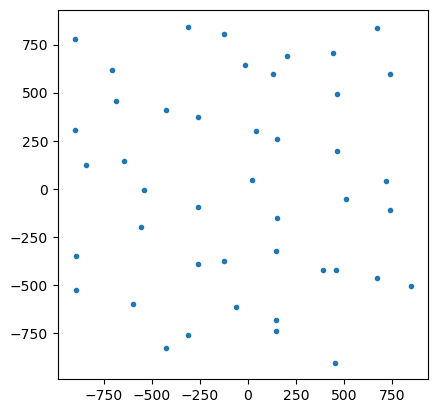

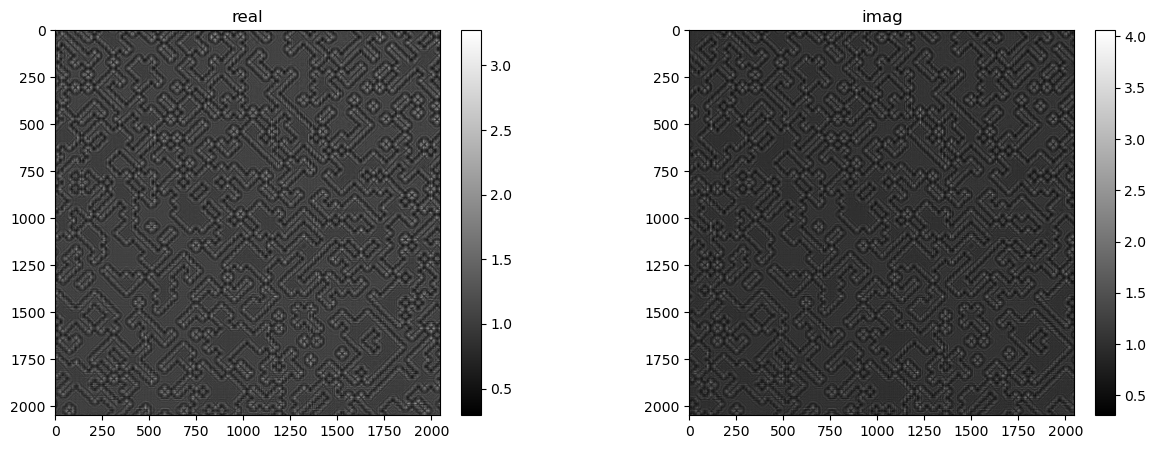

npos=44


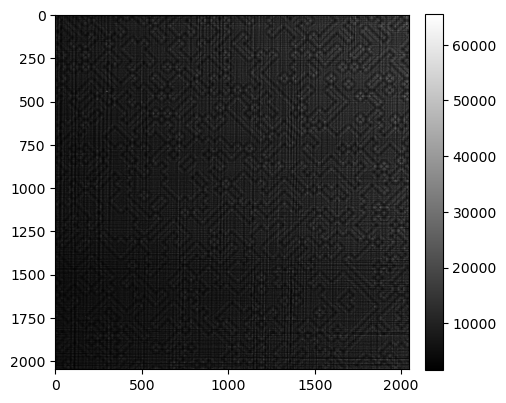

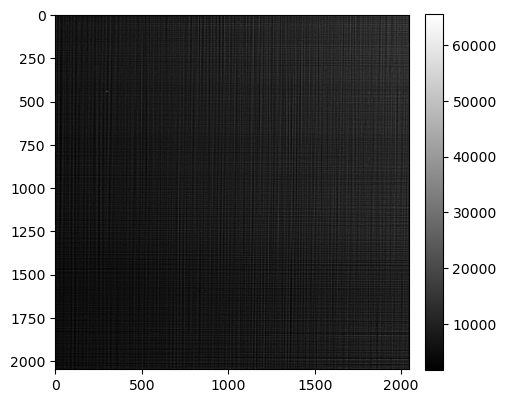

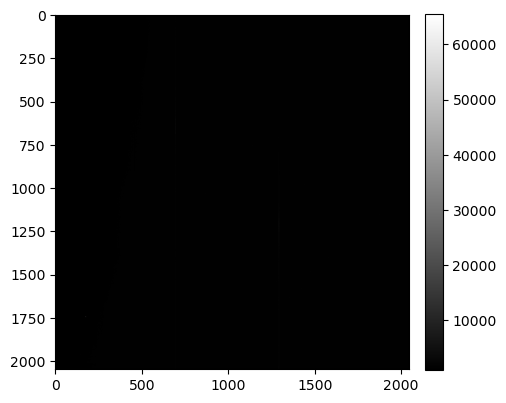

In [3]:
with h5py.File('/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/code2um_nfp18x18_01/code2um_nfp18x18_010000.h5') as fid:
    data0 = fid['/entry_0000/measurement/data'][:npos].astype('float32')
    
with h5py.File('/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/code2um_nfp18x18_01/ref_0000.h5') as fid:
    ref0 = fid['/entry_0000/measurement/data'][:].astype('float32')
with h5py.File('/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/code2um_nfp18x18_01/dark_0000.h5') as fid:
    dark0 = fid['/entry_0000/measurement/data'][:].astype('float32')

data0 = data0[np.newaxis]

shifts_code0 = np.loadtxt(f'/data/vnikitin/ESRF/ID16A/20240924/positions/shifts_code_nfp18x18ordered.txt')[np.newaxis,:,::-1]
shifts_code0 = shifts_code0/voxelsize*1e-6
print(shifts_code0[0,:10])

shifts_code0 = np.load(f'shifts_code_new.npy')
print(shifts_code0[0,:10])
shifts_code0 += 150# it appears like that
shifts_code0[:,:,1]*=-1

shifts_code0 = shifts_code0.reshape(1,int(np.sqrt(npos)),int(np.sqrt(npos)),2)
shifts_code0 = shifts_code0[:,::pos_step,::pos_step,:].reshape(1,npos//pos_step**2,2)
data0 = data0.reshape(1,int(np.sqrt(npos)),int(np.sqrt(npos)),n,n)
data0 = data0[:,::pos_step,::pos_step,:].reshape(1,npos//pos_step**2,n,n)

ids = np.where((np.abs(shifts_code0[0,:,0])<ne//2-n//2)*(np.abs(shifts_code0[0,:,1])<ne//2-n//2))[0]#[0:2]
data0 = data0[:,ids]
shifts_code0 = shifts_code0[:,ids]

print(shifts_code0.shape)
plt.plot(shifts_code0[0,:,0],shifts_code0[0,:,1],'.')
plt.axis('square')
plt.show()

mshow_complex(data0[0,0]/ref0[0]+1j*data0[0,1]/ref0[0],show)
npos = len(ids)
print(f'{npos=}')
mshow(data0[0,0],show)
mshow(ref0[0],show)
mshow(dark0[0],show)

In [4]:
data = data0.copy()
ref = ref0.copy()
dark = dark0.copy()
for k in range(npos):
    radius = 7
    threshold = 20000
    data[:,k] = remove_outliers(data[:,k], radius, threshold)
ref[:] = remove_outliers(ref[:], radius, threshold)     
dark[:] = remove_outliers(dark[:], radius, threshold)     

# data[data<=0] = 0
# ref[ref<=0] = 0

data/=np.mean(ref)
dark/=np.mean(ref)
ref/=np.mean(ref)

rdata = (data-np.mean(dark,axis=0))/(np.mean(ref,axis=0)-np.mean(dark,axis=0))


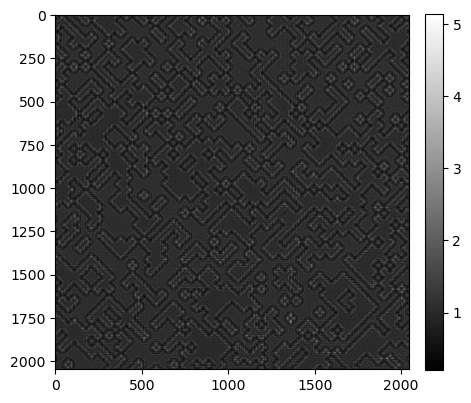

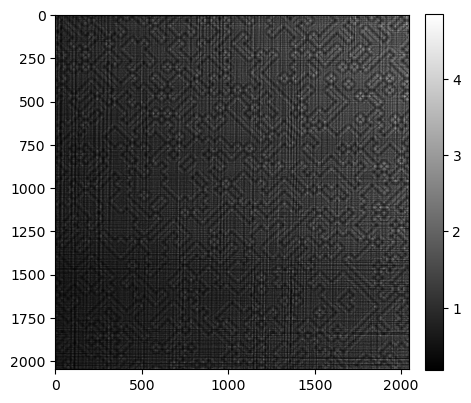

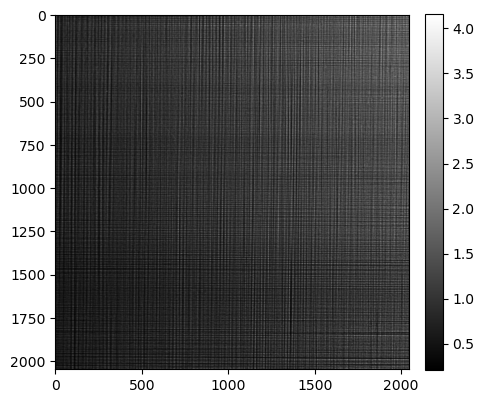

In [5]:
mshow(rdata[0,0],show)
mshow(data[0,0],show)
mshow(ref[0],show)

# Construct operators


In [6]:
def Lop(psi):
    psi = cp.array(psi)
    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi[:,i].copy()       
        psir = G(psir, wavelength, voxelsize, distances[i])
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def LTop(data):
    psi = cp.zeros([data.shape[0],npos, n+2*pad, n+2*pad], dtype='complex64')
    for j in range(npos):
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad))).astype('complex64')
        psir = GT(psir, wavelength, voxelsize, distances[j])        
        psi[:,j] = psir
    return psi

def Sop(psi,shifts):
    psi = cp.array(psi)
    data = cp.zeros([psi.shape[0], npos, n+2*pad, n+2*pad], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()    
        psir = S(psir, shifts[:, i])
        nee = psir.shape[1]        
        data[:,i] = psir[:, nee//2-n//2-pad:nee//2+n//2+pad, nee//2-n//2-pad:nee//2+n//2+pad]
    return data

def STop(data,shifts):
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:,j],((0,0),(ne//2-n//2-pad,ne//2-n//2-pad),(ne//2-n//2-pad,ne//2-n//2-pad)))        
        psi += ST(psir,shifts[:,j])
    return psi

tmp = cp.array(data)
arr1 = cp.pad(tmp[:,0],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')     
prb1 = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
shifts = cp.array(shifts_code0)
arr2 = Sop(arr1,shifts*rho)
arr3 = STop(arr2,shifts*rho)

arr4 = Lop(arr2)
arr5 = LTop(arr4)

print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')
print(f'{cp.sum(arr2*cp.conj(arr5))}==\n{cp.sum(arr4*cp.conj(arr4))}')

(379578464+49.58739471435547j)==
(379578464+2.2687318690373104e-09j)
(237197136-8.12109375j)==
(237197136+1.8759201338980347e-05j)


#### Reconstruction with the CG (Carlsson) with Hessians

In [7]:
def reprod(a,b):
    return a.real*b.real+a.imag*b.imag

def redot(a,b,axis=None):
    return cp.sum(reprod(a,b),axis=axis)

def gradientF(psi,q,x,d):
    Lpsi = Lop(Sop(psi,x)*q)
    td = d*(Lpsi/cp.abs(Lpsi))
    res = 2*LTop(Lpsi - td)
    return res

def hessianF(hpsi,hpsi1,hpsi2,data):
    Lpsi = Lop(hpsi)        
    Lpsi1 = Lop(hpsi1)
    Lpsi2 = Lop(hpsi2)    
    l0 = Lpsi/cp.abs(Lpsi)
    d0 = data/cp.abs(Lpsi)
    v1 = cp.sum((1-d0)*reprod(Lpsi1,Lpsi2))
    v2 = cp.sum(d0*reprod(l0,Lpsi1)*reprod(l0,Lpsi2))    
    return 2*(v1+v2)

def Twop(psi,x,w):
    data = cp.zeros([psi.shape[0], npos, n+2*pad, n+2*pad], dtype='complex64')
    xi1 = cp.fft.fftfreq(2*ne).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    for i in range(npos):
        psir = psi.copy()            
        p = x[:,i]
        psir = cp.pad(psir, ((0, 0), (ne//2, ne//2), (ne//2, ne//2)), 'constant')
        pp = w*cp.exp(-2*cp.pi*1j*(xi1*p[:, 0, None, None]+xi2*p[:, 1, None, None]))    
        psir = cp.fft.ifft2(pp*cp.fft.fft2(psir))   
        data[:,i] = psir[:, ne-n//2-pad:ne+n//2+pad, ne-n//2-pad:ne+n//2+pad]        
    return data

def gradientx(psi,q,x,gradF):
    xi1 = cp.fft.fftfreq(2*psi.shape[-1]).astype('float32')    
    [xi2, xi1] = cp.meshgrid(xi1, xi1)  
    tksi1 = Twop(psi,x,-2*cp.pi*1j*xi1)
    tksi2 = Twop(psi,x,-2*cp.pi*1j*xi2)
    
    gradx = cp.zeros([1,npos,2],dtype='float32')
    tmp = cp.conj(q)*gradF
    gradx[:,:,0] = redot(tmp,tksi1,axis=(2,3))
    gradx[:,:,1] = redot(tmp,tksi2,axis=(2,3))
    return gradx

def gradients(psi,q,x,d):
    gradF = gradientF(psi,q,x,d)
    gradpsi = STop(cp.conj(q)*gradF,x)
    gradq = cp.sum(cp.conj(Sop(psi,x))*gradF,axis=1)
    gradx = rho*gradientx(psi,q,x,gradF)
    return gradpsi,gradq,gradx

def DT(psi,x,dx):
    xi1 = cp.fft.fftfreq(2*psi.shape[-1]).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    tksi1 = Twop(psi,x,-2*cp.pi*1j*xi1)
    tksi2 = Twop(psi,x,-2*cp.pi*1j*xi2)
    res = tksi1*dx[:,:,0,None,None]+tksi2*dx[:,:,1,None,None]
    return res

def D2T(psi,x,dx1,dx2):
    xi1 = cp.fft.fftfreq(2*psi.shape[-1]).astype('float32')
    [xi2,xi1] = cp.meshgrid(xi1, xi1)
    dx11 = dx1[:,:,:,None,None] 
    dx22 = dx2[:,:,:,None,None] 
    res = dx11[:,:,0]*dx22[:,:,0]*Twop(psi,x,-4*cp.pi**2*xi1**2)+ \
         (dx11[:,:,0]*dx22[:,:,1]+dx11[:,:,1]*dx22[:,:,0])*Twop(psi,x,-4*cp.pi**2*xi1*xi2)+ \
          dx11[:,:,1]*dx22[:,:,1]*Twop(psi,x,-4*cp.pi**2*xi2**2)
    return res

def DM(psi,q,x,dpsi,dq,dx):
    res = dq*Sop(psi,x)+q*(Sop(dpsi,x)+rho*DT(psi,x,dx))   
    return res

def D2M(psi,q,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2):    
    res =  q*rho*DT(dpsi1,x,dx2) + q*rho*DT(dpsi2,x,dx1) + q*rho**2*D2T(psi,x,dx1,dx2)  
    res += dq1*Sop(dpsi2,x) + dq2*Sop(dpsi1,x) 
    res += dq1*rho*DT(psi,x,dx2) + dq2*rho*DT(psi,x,dx1)
    return res

def hessian2(psi,q,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2,data):
    gradF = gradientF(psi,q,x,data)
    res = redot(gradF,D2M(psi,q,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2))
    res += hessianF(Sop(psi,x)*q, DM(psi,q,x,dpsi1,dq1,dx1), DM(psi,q,x,dpsi2,dq2,dx2),data)         
    return res

In [8]:
def rec_init(rdata,shifts):
    recMultiPaganin = cp.zeros([1,npos,ne,ne],dtype='float32')
    recMultiPaganinr = cp.zeros([1,npos,ne,ne],dtype='float32')# to compensate for overlap
    for j in range(0,npos):
        r = multiPaganin(rdata[:,j:j+1],
                            distances[j:j+1], wavelength, voxelsize,  24.05, 5e-2)    
        rr = r*0+1 # to compensate for overlap
        r = cp.pad(r,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
        rr = cp.pad(rr,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
        recMultiPaganin[:,j] = ST(r,shifts[:,j])
        recMultiPaganinr[:,j] = ST(rr,shifts[:,j])
        
    recMultiPaganin = cp.sum(recMultiPaganin,axis=1)
    recMultiPaganinr = cp.sum(recMultiPaganinr,axis=1)

    # avoid division by 0
    recMultiPaganinr[np.abs(recMultiPaganinr)<5e-2] = 1

    # compensate for overlap
    recMultiPaganin /= recMultiPaganinr
    recMultiPaganin = cp.exp(1j*recMultiPaganin)

    mshow_polar(recMultiPaganin[0],show)
    mshow_polar(recMultiPaganin[0,pad:-pad,pad:-pad],show)
    return recMultiPaganin


In [9]:
def minf(fpsi,data):
    f = np.linalg.norm(np.abs(fpsi)-data)**2
    return f

def plot_debug2(psi,prb,shifts,etapsi,etaprb,etashift,top,bottom,gammah,data):
    npp = 17
    errt = np.zeros(npp*2)
    errt2 = np.zeros(npp*2)
    for k in range(0,npp*2):
        psit = psi+(gammah*k/(npp-1))*etapsi
        prbt = prb+(gammah*k/(npp-1))*etaprb
        shiftst = shifts+(gammah*k/(npp-1))*etashift
        fpsit = Lop(Sop(psit,shiftst*rho)*prbt)
        errt[k] = minf(fpsit,data)    

    t = gammah*(cp.arange(2*npp))/(npp-1)
    errt2 = minf(Lop(Sop(psi,shifts*rho)*prb),data)-top*t+0.5*bottom*t**2
    
    plt.plot(gammah.get()*np.arange(2*npp)/(npp-1),errt,'.')
    plt.plot(gammah.get()*np.arange(2*npp)/(npp-1),errt2.get(),'.')
    plt.show()

def plot_debug3(shifts,shifts_init):
    plt.plot(shifts_init[0,:,0].get()*rho-(shifts[0,:,0]).get()*rho,'r.')
    plt.plot(shifts_init[0,:,1].get()*rho-(shifts[0,:,1]).get()*rho,'b.')
    plt.show()

/tmp/ipykernel_1797175/1329226912.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  recMultiPaganin[:,j] = ST(r,shifts[:,j])
/tmp/ipykernel_1797175/1329226912.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  recMultiPaganinr[:,j] = ST(rr,shifts[:,j])


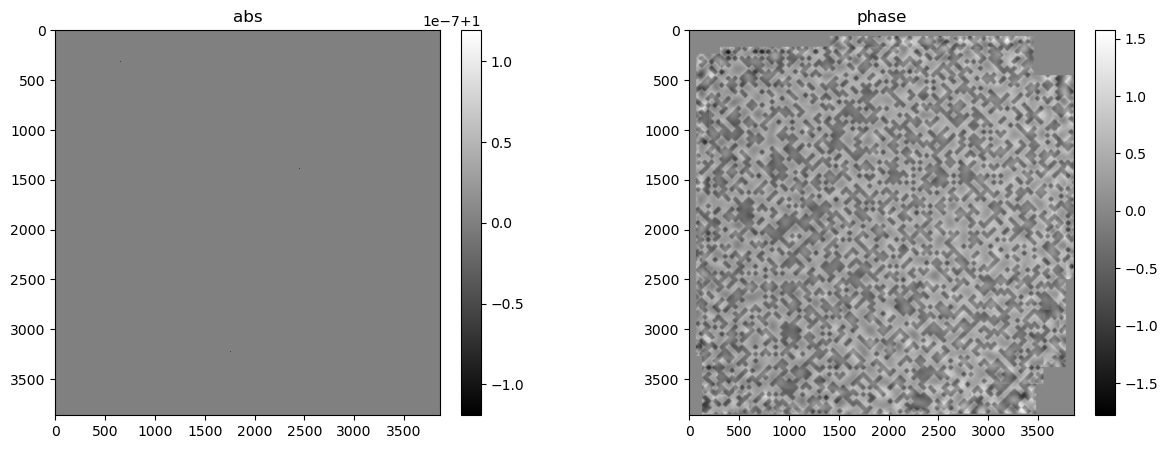

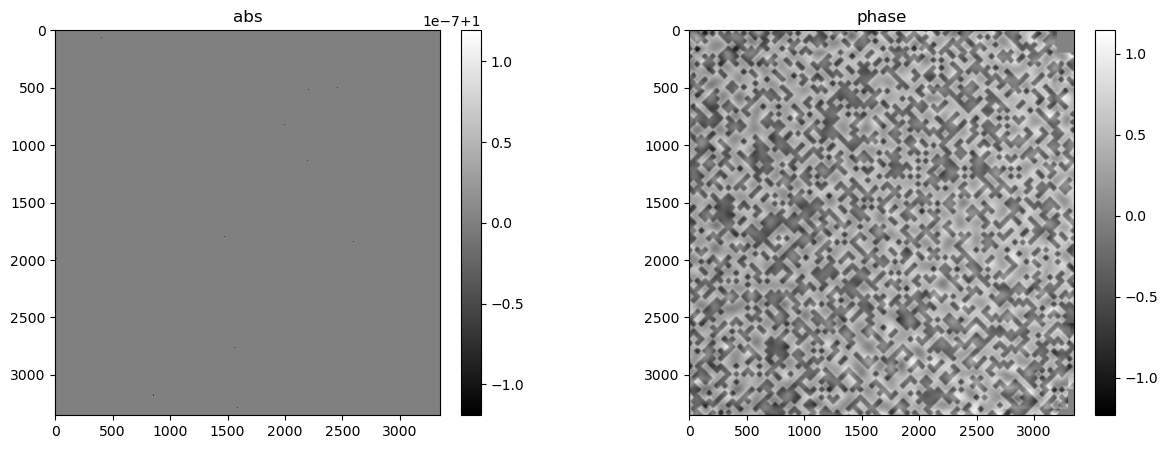

gradient norms (psi, prb, shift): 11591.32, 32620.47, 910.20


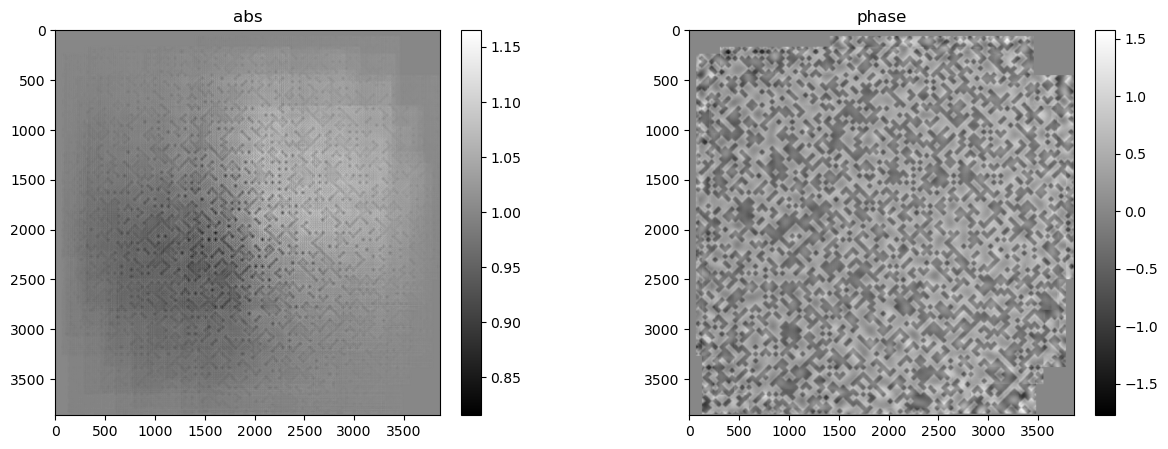

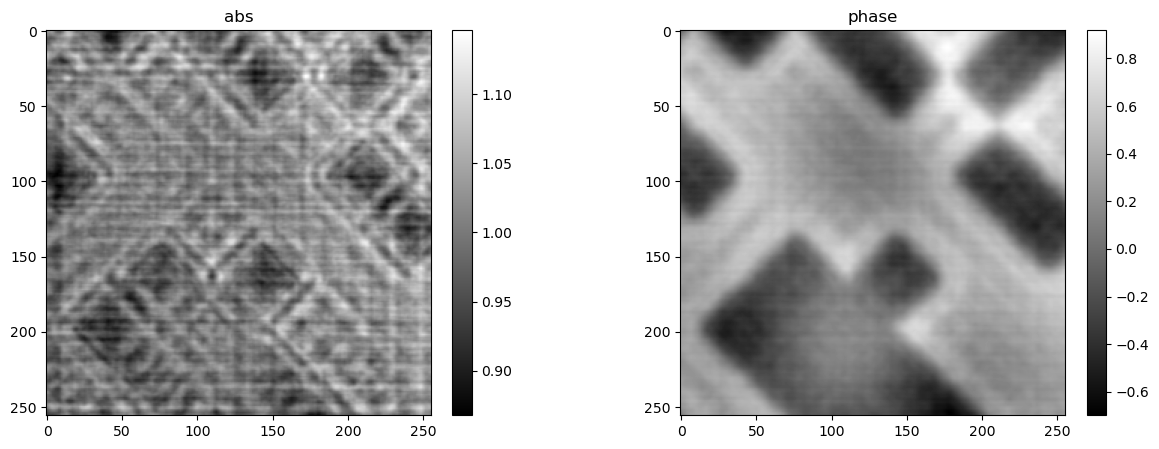

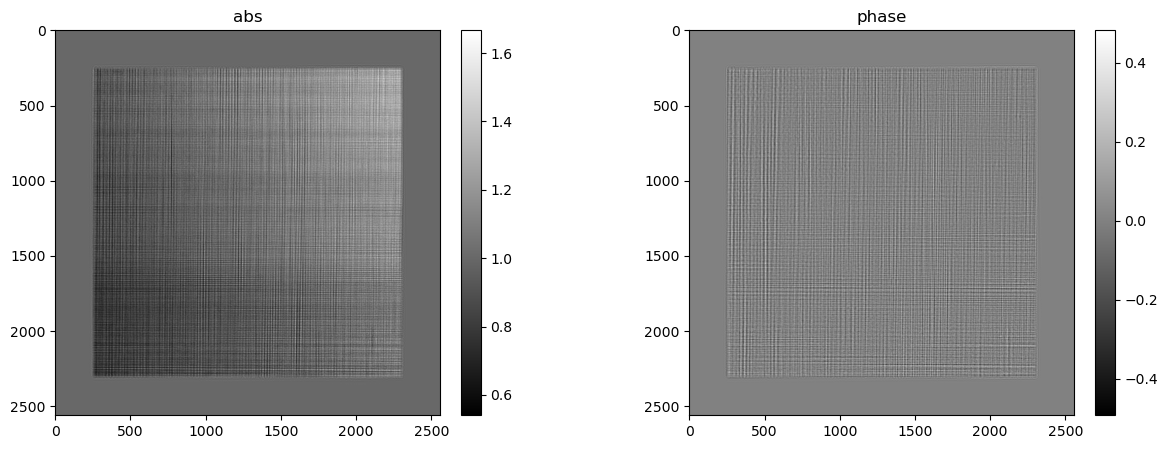

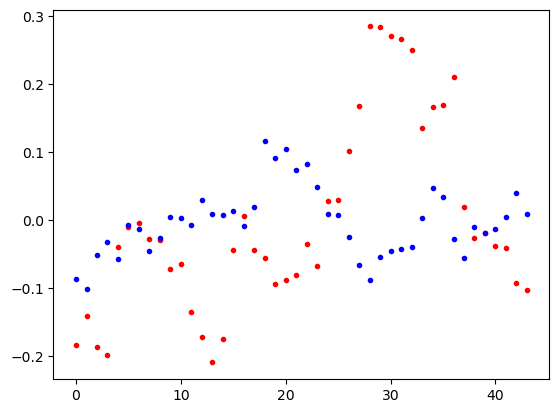

0) alpha=0.01076, err=1.13894e+06
gradient norms (psi, prb, shift): 5263.69, 4423.65, 1225.71
1) alpha=0.01538, err=7.68990e+05
gradient norms (psi, prb, shift): 2086.60, 3007.96, 1209.76
2) alpha=0.03031, err=5.57188e+05
gradient norms (psi, prb, shift): 2632.17, 2242.92, 655.57
3) alpha=0.01957, err=4.50627e+05
gradient norms (psi, prb, shift): 2145.19, 1760.13, 309.48
4) alpha=0.01791, err=3.86095e+05
gradient norms (psi, prb, shift): 1559.03, 1228.53, 319.02
5) alpha=0.02263, err=3.42764e+05
gradient norms (psi, prb, shift): 1172.82, 900.93, 241.70


In [10]:
def cg_holo(data, psi, prb, shifts, pars):

    data = np.sqrt(data)    
    shifts_init = shifts.copy()
    conv = np.zeros(pars['niter'])
    alphaa = np.zeros(pars['niter'])    
    
    for i in range(pars['niter']):                                                
        # print(f"ITERATION {i}")        
        
        gradpsi, gradprb, gradshift = gradients(psi,prb,shifts*rho,data)
        print(f'gradient norms (psi, prb, shift): {cp.linalg.norm(gradpsi):.2f}, {cp.linalg.norm(gradprb):.2f}, {cp.linalg.norm(gradshift):.2f}')                        
        
        if i==0:
            etapsi = -gradpsi
            etaprb = -gradprb
            etashift = -gradshift
        else:      
            beta = hessian2(psi,prb,shifts*rho,gradpsi,gradprb,gradshift,etapsi,etaprb,etashift,data)/\
                   hessian2(psi,prb,shifts*rho, etapsi, etaprb, etashift,etapsi,etaprb,etashift,data)                        
            etapsi = -gradpsi + beta*etapsi
            etaprb = -gradprb + beta*etaprb
            etashift = -gradshift + beta*etashift            
        
        top = -(redot(gradpsi,etapsi)+
                redot(gradprb,etaprb)+
                redot(gradshift,etashift))       
        bottom = hessian2(psi,prb,shifts*rho,etapsi,etaprb,etashift,
                                         etapsi,etaprb,etashift,data)
        alpha = top/bottom        
        
        psi += alpha*etapsi
        prb += alpha*etaprb
        shifts += alpha*etashift
        
        if i % pars['vis_step'] == 0:
            mshow_polar(psi[0],show)
            mshow_polar(psi[0,ne//2-128:ne//2+128,ne//2-128:ne//2+128],show)
            mshow_polar(prb[0],show)
            dxchange.write_tiff(cp.angle(psi[0]).get(),f'{path}/crec_code_angle{flg}/{i:03}',overwrite=True)
            dxchange.write_tiff(cp.angle(prb[0]).get(),f'{path}/crec_prb_angle{flg}/{i:03}',overwrite=True)
            dxchange.write_tiff(cp.abs(psi[0]).get(),f'{path}/crec_code_abs{flg}/{i:03}',overwrite=True)
            dxchange.write_tiff(cp.abs(prb[0]).get(),f'{path}/crec_prb_abs{flg}/{i:03}',overwrite=True)
            plot_debug3(shifts,shifts_init)

        if i % pars['err_step'] == 0:
            fpsi = Lop(Sop(psi,shifts*rho)*prb)
            err = minf(fpsi,data)
            conv[i] = err
            alphaa[i] = alpha
            print(f'{i}) {alpha=:.5f}, {err=:1.5e}')
        
    return conv,alphaa

data = cp.array(data)
rdata = cp.array(rdata)
rec_shifts = cp.array(shifts/rho)

rec_psi = rec_init(rdata,rec_shifts*rho)
rec_prb = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')

pars = {'niter': 257, 'err_step': 1, 'vis_step': 16}
rec_psi = rec_psi[:,rec_psi.shape[1]//2-ne//2:rec_psi.shape[1]//2+ne//2,rec_psi.shape[2]//2-ne//2:rec_psi.shape[2]//2+ne//2]

conv,alphaa = cg_holo(data,rec_psi,rec_prb,rec_shifts, pars)   